Data Preparation

In [3]:
import os
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_text, plot_tree
from sklearn.neighbors import NearestNeighbors

# from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

Load Dataset

In [18]:
sepsis_data = pd.read_csv('dataset/sepsis_dataset.csv')
print("✅ Dataset Loaded Successfully")
print(sepsis_data.head(10))

✅ Dataset Loaded Successfully
   survival  THERAPY  PRAPACHE     AGE  BLGCS  ORGANNUM    BLIL6     BLLPLAT  \
0         0        1        19  42.921     15         1   301.80  191.000000   
1         1        1        48  68.818     11         2   118.90  264.156481   
2         0        1        20  68.818     15         2    92.80  123.000000   
3         0        1        19  33.174     14         2  1232.00  244.000000   
4         0        1        48  46.532      3         4  2568.00   45.000000   
5         0        0        21  56.098     14         1   162.65  137.000000   
6         1        0        19  68.818     15         2  2568.00   45.000000   
7         0        1        19  46.532     15         3  4952.00   92.000000   
8         0        1        22  56.098     15         3   118.90  148.601978   
9         1        1        19  56.098     10         3  2568.00  109.000000   

    BLLBILI  BLLCREAT  TIMFIRST      BLADL  blSOFA  
0  2.913416  1.000000     17.17   0.

Outcome = "survival"
Treatement = "THERAPY"

Data preprocessing and splitting

In [ ]:
X = sepsis_data.drop(columns=['survival'])
y = sepsis_data['survival']

Single Random Forest

OOB predictions are used to estimate E(Y|T = realtreatment). Then, treatement is switched, it means that 1 becomes 0 and 0 becomes 1. We use again model to estimate E(Y|T = theothertreatment).
This is what computeTwin1() and computeTwin2() functions do.



In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
rf.fit(X_train, y_train)

# T = realtreatment
Twin_1 = rf.predict_proba(X_test)[:, 1]

# switch treatment
X_test_counterfactual = X_test.copy()
X_test_counterfactual['THERAPY'] = 1 - X_test_counterfactual['THERAPY']

# T = theothertreatment
Twin_2 = rf.predict_proba(X_test_counterfactual)[:, 1]

# ITE
SRF_ITE = np.where(X_test['THERAPY'] == 1, Twin_1 - Twin_2, Twin_2 - Twin_1)

SRF = X_test.copy()
SRF['Outcome'] = y_test
SRF['Twin_1'] = Twin_1
SRF['Twin_2'] = Twin_2
SRF['ITE'] = SRF_ITE

# output_path = os.path.join("Results", "SimpleRandomForest.csv")
# SRF.to_csv(output_path, index=False)

print(SRF.head())

     THERAPY  PRAPACHE     AGE  BLGCS  ORGANNUM    BLIL6  BLLPLAT  BLLBILI  \
55         1        48  68.818      3         5  12998.0     78.0      4.8   
73         1        19  38.113      8         1    301.8    359.0      1.9   
33         1        20  46.532     13         4  12998.0     78.0      1.2   
446        0        27  73.138      8         1   1232.0    172.0      0.5   
425        1        23  73.138     15         4    212.3     62.0      1.6   

     BLLCREAT  TIMFIRST      BLADL  blSOFA  Outcome  Twin_1  Twin_2   ITE  
55       20.0     59.17   4.050222    17.0        1    0.46    0.38  0.08  
73        1.0     27.08   0.000000     5.0        0    0.11    0.23 -0.12  
33        3.0     30.67   1.619632    12.0        0    0.05    0.14 -0.09  
446       2.0     67.50  12.000000     7.0        0    0.48    0.51  0.03  
425       3.8     50.67   0.000000    10.0        0    0.13    0.13  0.00  


Double Random Forest

E(Y|T =1) if Ti = 1 is estimated by OOB predictions from model_trt1. E(Y|T = 0) if Ti = 0 is estimated by OOB predictions from model_trt0. This is what computeTwin1() does.

Then E(Y|T = 1)if Ti = 0 isestimated by model_trt1. Then E(Y|T = 0) if Ti = 1 is estimated by model_trt1. This is what computeTwin2() does

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_trt1 = X_train[X_train['THERAPY'] == 1]
y_train_trt1 = y_train[X_train['THERAPY'] == 1]
X_train_trt0 = X_train[X_train['THERAPY'] == 0]
y_train_trt0 = y_train[X_train['THERAPY'] == 0]
X_test_trt1 = X_test[X_test['THERAPY'] == 1]
X_test_trt0 = X_test[X_test['THERAPY'] == 0]

model_trt1 = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
model_trt1.fit(X_train_trt1, y_train_trt1)

model_trt0 = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
model_trt0.fit(X_train_trt0, y_train_trt0)

# Compute Twin 1
twin1_scores = np.zeros(len(X_test))

# Fill in the scores based on the original index
twin1_scores[X_test['THERAPY'] == 1] = model_trt1.predict_proba(X_test_trt1)[:, 1]
twin1_scores[X_test['THERAPY'] == 0] = model_trt0.predict_proba(X_test_trt0)[:, 1]

# Compute Twin 2
twin2_scores = np.zeros(len(X_test))

# CROSS OVER: Feed X_1 into rf0, and X_0 into rf1
twin2_scores[X_test['THERAPY'] == 1] = model_trt0.predict_proba(X_test_trt1)[:, 1]
twin2_scores[X_test['THERAPY'] == 0] = model_trt1.predict_proba(X_test_trt0)[:, 1]

DRF_ITE = np.zeros(len(X_test))

# For the Treated group (T=1):
#   P(Y=1|T=1) is Twin 1 (Factual)
#   P(Y=1|T=0) is Twin 2 (Counterfactual)
DRF_ITE[X_test['THERAPY'] == 1] = twin1_scores[X_test['THERAPY'] == 1] - twin2_scores[X_test['THERAPY'] == 1]

# For the Control group (T=0):
#   P(Y=1|T=1) is Twin 2 (Counterfactual)
#   P(Y=1|T=0) is Twin 1 (Factual)
DRF_ITE[X_test['THERAPY'] == 0] = twin2_scores[X_test['THERAPY'] == 0] - twin1_scores[X_test['THERAPY'] == 0]

K Fold Random Forest

Twins are estimated by k-fold cross validation. A forest is computed on k-1/k of the data and then used to estimate twin1 and twin2 on 1/k of the left data

In [16]:
def compute_kfold_single_rf(X, y, T, treatment_col_name='THERAPY', k=5):
    """
    Computes P1 (prob if treated) and P0 (prob if control) 
    using K-Fold Cross Validation with a SINGLE Random Forest (S-Learner).
    """
    
    # 1. Initialize arrays
    p1_cv = np.zeros(len(X))
    p0_cv = np.zeros(len(X))
    
    # 2. Setup Stratified K-Fold
    # We still stratify by Treatment to ensure good balance in training
    kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    

    # 3. Loop through folds
    for fold_i, (train_index, val_index) in enumerate(kf.split(X, T)):
        
        # --- A. Prepare Training Data ---
        # Get Features for training fold
        X_train_fold = X.iloc[train_index].copy()
        y_train_fold = y.iloc[train_index]
        T_train_fold = T.iloc[train_index]
        
        # CRITICAL STEP: Add the Treatment column into X as a feature
        # The Single Forest must see 'THERAPY' to learn its effect
        X_train_fold[treatment_col_name] = T_train_fold
        
        # --- B. Train ONE Model ---
        # Train on the WHOLE fold (both Treated and Control mixed)
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X_train_fold, y_train_fold)
        
        # --- C. Predict on Validation Fold (Counterfactuals) ---
        # Get Features for validation fold
        X_val_fold = X.iloc[val_index]
        
        # 1. Create a dataset where everyone is forced to TREATMENT (T=1)
        X_val_forced_1 = X_val_fold.copy()
        X_val_forced_1[treatment_col_name] = 1
        
        # 2. Create a dataset where everyone is forced to CONTROL (T=0)
        X_val_forced_0 = X_val_fold.copy()
        X_val_forced_0[treatment_col_name] = 0
        
        # 3. Predict Probabilities
        # The model uses the 'THERAPY' column to adjust the prediction
        p1_probs = rf.predict_proba(X_val_forced_1)[:, 1]
        p0_probs = rf.predict_proba(X_val_forced_0)[:, 1]
        
        # Store in arrays
        p1_cv[val_index] = p1_probs
        p0_cv[val_index] = p0_probs

    # 4. Calculate ITE
    ite_cv = p1_cv - p0_cv
    
    return p1_cv, p0_cv, ite_cv

# --- USAGE ---
# Note: Pass the string name of your therapy column so it can be added correctly
P1_vec, P0_vec, KF_ITE = compute_kfold_single_rf(
    X, 
    y, 
    sepsis_data['THERAPY'], 
    treatment_col_name='THERAPY', 
    k=5
)

# Add to dataframe
KF = sepsis_data.copy()
KF['P1_CV'] = P1_vec
KF['P0_CV'] = P0_vec
KF['ITE_CV'] = KF_ITE

Subgroups and plots

Regression Tree

Single Random Forest Method

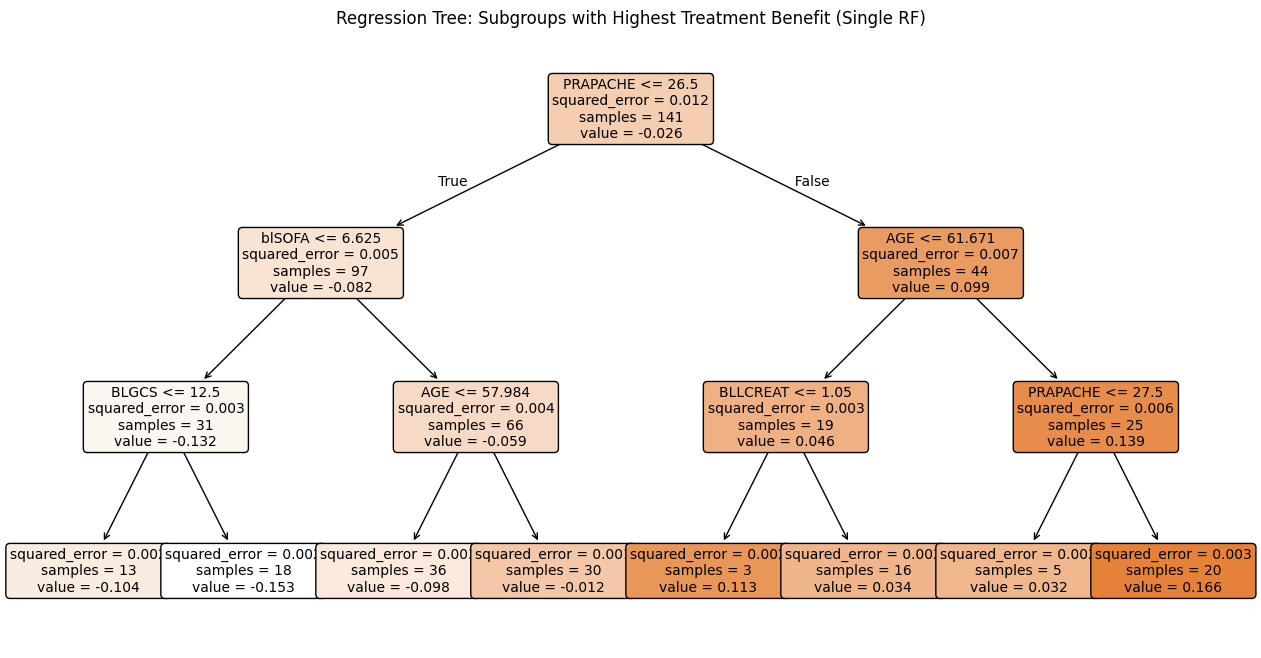

In [9]:
X_features = X_test.drop(columns=['THERAPY'])

reg_SRF = DecisionTreeRegressor(max_depth=3, min_samples_split=10, random_state=42)
reg_SRF.fit(X_features, SRF_ITE)

plt.figure(figsize=(16, 8))
plot_tree(
    reg_SRF,
    feature_names=X_features.columns,
    filled=True,        
    rounded=True,
    precision=3,
    fontsize=10
)

plt.title("Regression Tree: Subgroups with Highest Treatment Benefit (Single RF)")
plt.show()

Double Random Forest Method

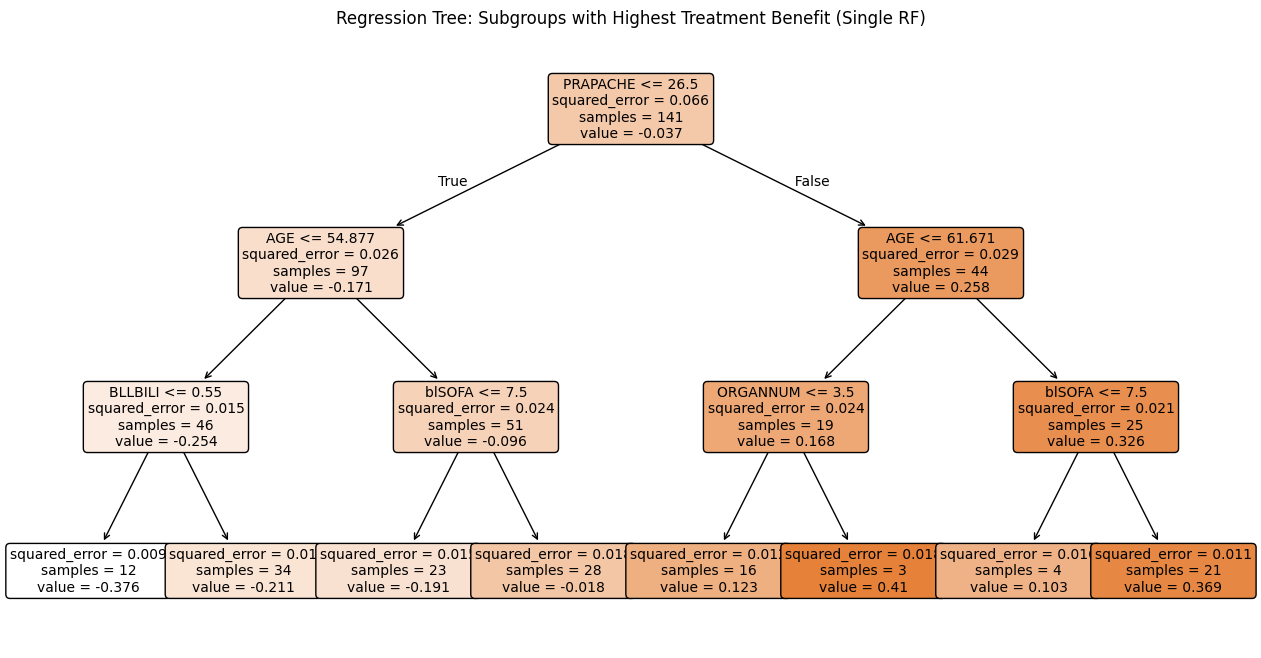

In [117]:
X_features = X_test.drop(columns=['THERAPY'], errors='ignore')

reg_DRF = DecisionTreeRegressor(max_depth=3, min_samples_split=10, random_state=42)
reg_DRF.fit(X_features, DRF_ITE)

# 3. Plot
plt.figure(figsize=(16, 8)) 
plot_tree(
    reg_DRF,
    feature_names=X_features.columns,
    filled=True,        
    rounded=True,
    precision=3,
    fontsize=10
)

plt.title("Regression Tree: Subgroups with Highest Treatment Benefit (Single RF)")
plt.show()

K Fold Method

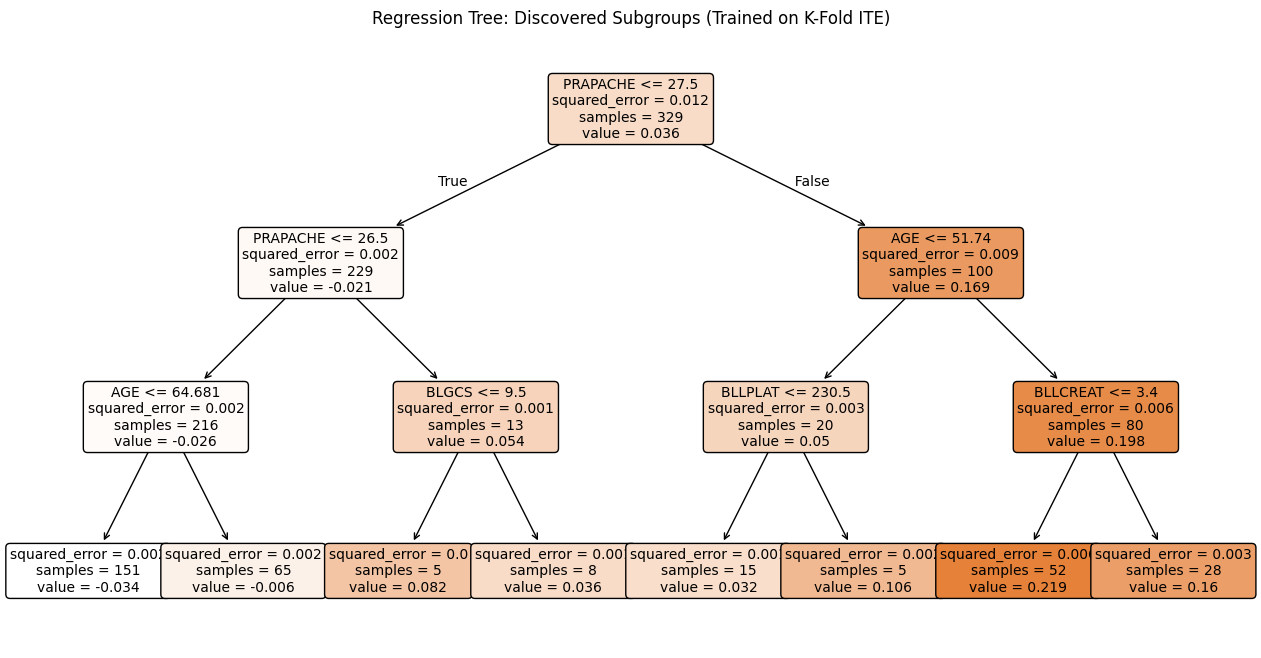

In [118]:
X_train_features = X_train.drop(columns=['THERAPY'], errors='ignore')

# Retrieve the ITEs for the training patients only
# We use .loc to match the Indices of X_train
y_train_ite = KF.loc[X_train.index, 'ITE_CV']

reg_KF = DecisionTreeRegressor(max_depth=3, min_samples_split=10, random_state=42)
reg_KF.fit(X_train_features, y_train_ite)

# 3. Plot the Tree
plt.figure(figsize=(16, 8))
plot_tree(
    reg_KF,
    feature_names=X_train_features.columns,
    filled=True,        
    rounded=True,
    precision=3,
    fontsize=10
)

plt.title("Regression Tree: Discovered Subgroups (Trained on K-Fold ITE)")
plt.show()

Classification Tree

$$
Z_i =
\begin{cases} 
1, & \text{if } ITE_i > 0 \\
0, & \text{otherwise}
\end{cases}
$$

Single Random Forest

In [10]:
thresholds = np.quantile(SRF_ITE, q=np.arange(0.5, 0.9, 0.1))

classification_trees_SRF = {}

for c in thresholds:
    Z_star = (SRF_ITE > c).astype(int)

    clf_SRF = DecisionTreeClassifier(max_depth=3, min_samples_split=10, random_state=42)
    clf_SRF.fit(X_features, Z_star)

    classification_trees_SRF[c] = clf_SRF

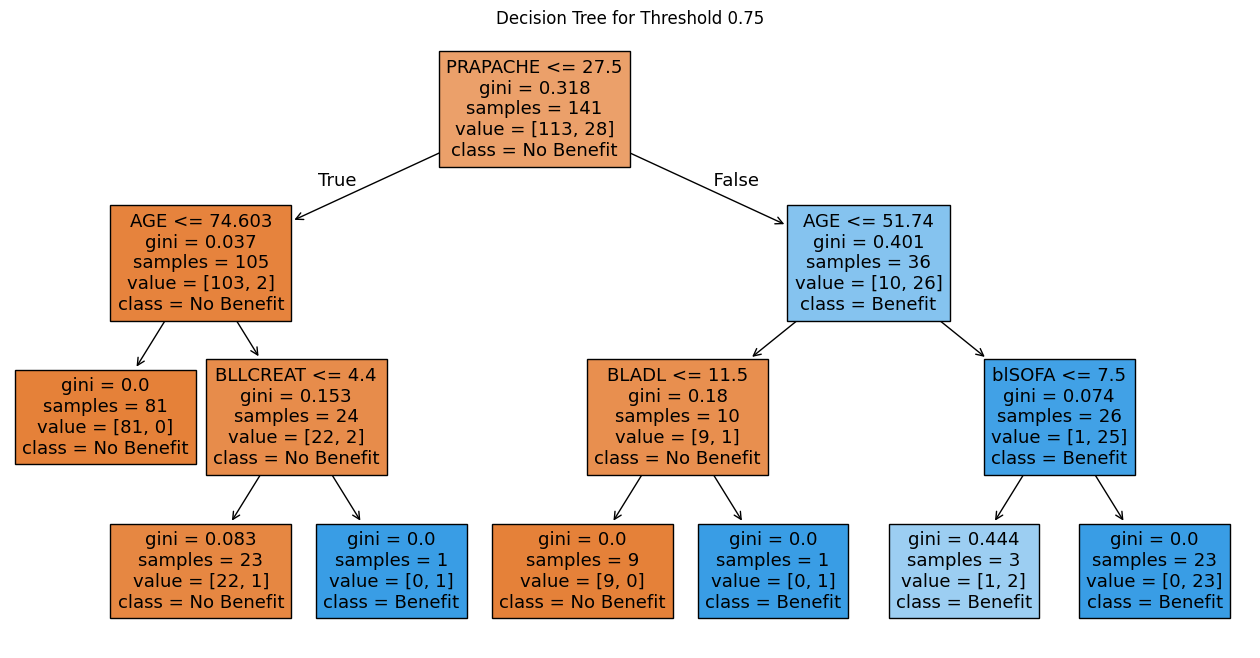

In [120]:
closest_threshold = 0.75
closest_key = min(classification_trees_SRF.keys(), key=lambda x: abs(x - closest_threshold))

plt.figure(figsize=(16, 8))
plot_tree(
    classification_trees_SRF[closest_key], 
    feature_names=X_features.columns, 
    class_names=["No Benefit", "Benefit"], 
    filled=True)
plt.title(f"Decision Tree for Threshold {closest_threshold}")
plt.show()

Double Random Forest

In [121]:
classification_trees_DRF = {}

for c in thresholds:
    Z_star = (DRF_ITE > c).astype(int)

    clf_DRF = DecisionTreeClassifier(max_depth=3, min_samples_split=10, random_state=42)
    clf_DRF.fit(X_features, Z_star)

    classification_trees_DRF[c] = clf_DRF

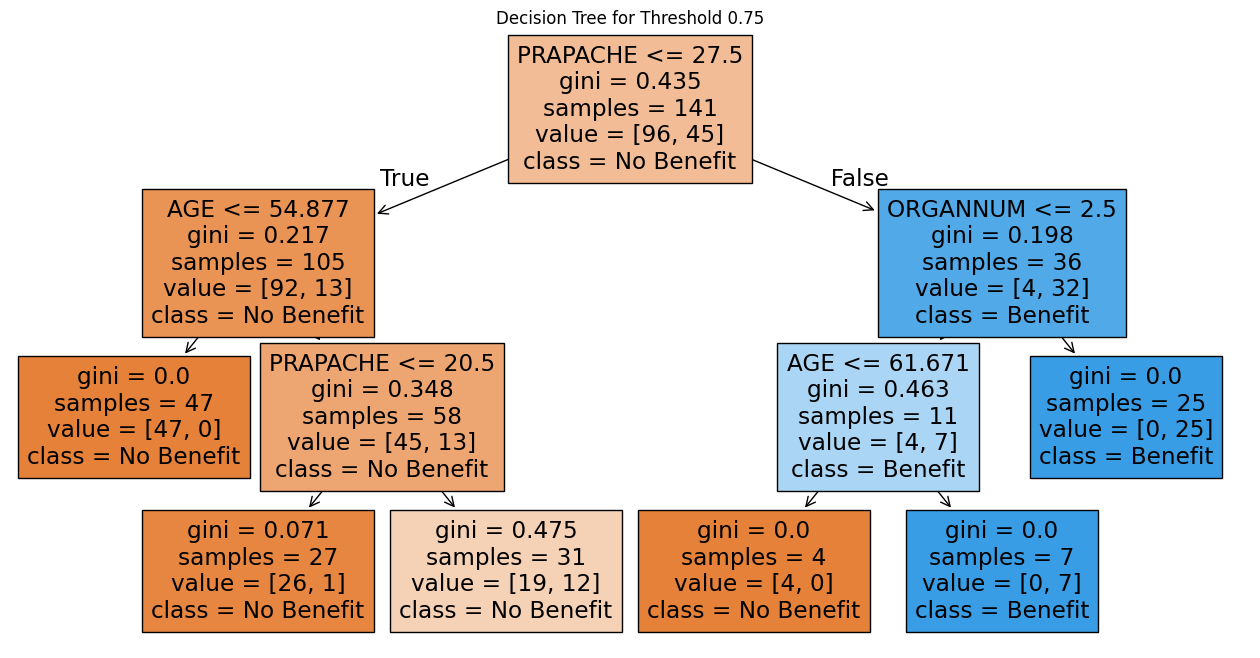

In [122]:
closest_key = min(classification_trees_DRF.keys(), key=lambda x: abs(x - closest_threshold))

plt.figure(figsize=(16, 8))
plot_tree(
    classification_trees_DRF[closest_key], 
    feature_names=X_features.columns, 
    class_names=["No Benefit", "Benefit"], 
    filled=True)
plt.title(f"Decision Tree for Threshold {closest_threshold}")
plt.show()

K Fold

In [123]:
classification_trees_KF = {}

for c in thresholds:
    # Use ITE values corresponding to the training set so labels match X_train_features length
    # y_train_ite was computed earlier as KF.loc[X_train.index, 'ITE_CV']
    Z_star = (y_train_ite > c).astype(int)

    clf_KF = DecisionTreeClassifier(max_depth=3, min_samples_split=10, random_state=42)
    clf_KF.fit(X_train_features, Z_star)

    classification_trees_KF[c] = clf_KF

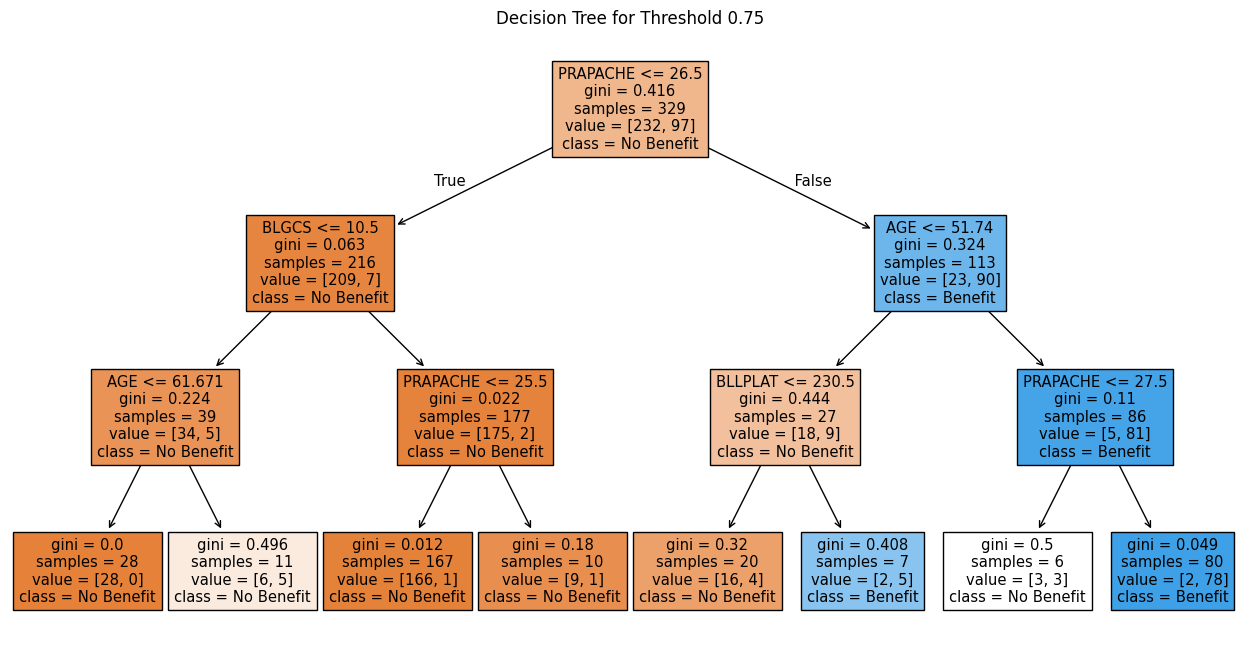

In [124]:
closest_key = min(classification_trees_KF.keys(), key=lambda x: abs(x - closest_threshold))

plt.figure(figsize=(16, 8))
plot_tree(
    classification_trees_KF[closest_key], 
    feature_names=X_features.columns, 
    class_names=["No Benefit", "Benefit"], 
    filled=True)
plt.title(f"Decision Tree for Threshold {closest_threshold}")
plt.show()

SHAP

Regression Tree Explanations

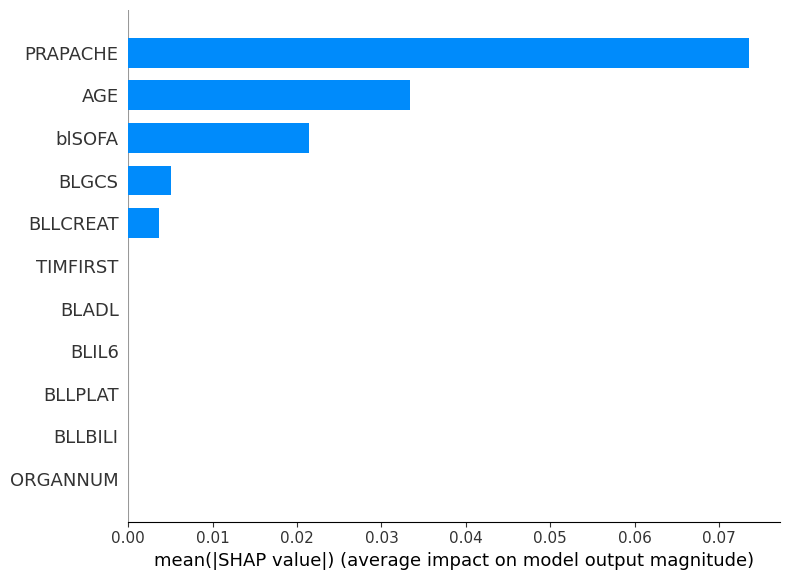

In [125]:
SRF_reg = shap.TreeExplainer(reg_SRF)
shap_SRF_reg = SRF_reg.shap_values(X_features)

shap.summary_plot(shap_SRF_reg, X_features, plot_type="bar", show=True)

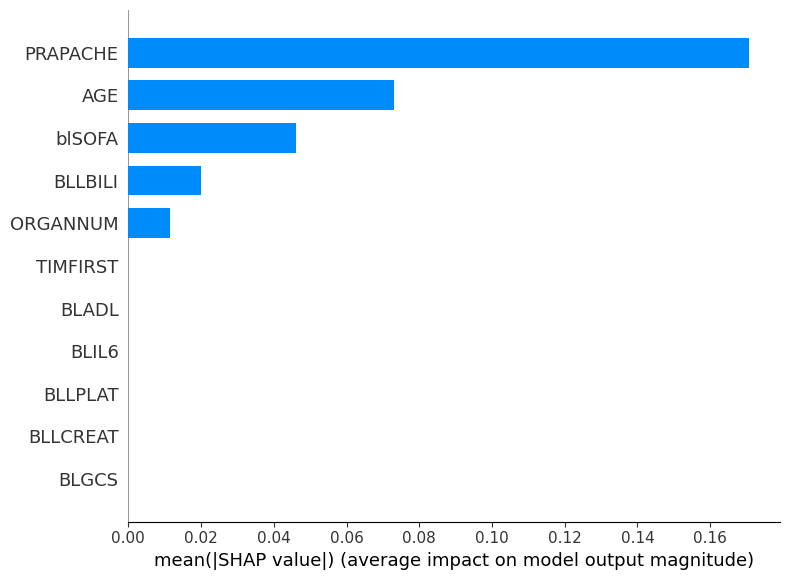

In [126]:
DRF_reg = shap.TreeExplainer(reg_DRF)
shap_DRF_reg = DRF_reg.shap_values(X_features)

shap.summary_plot(shap_DRF_reg, X_features, plot_type="bar", show=True)

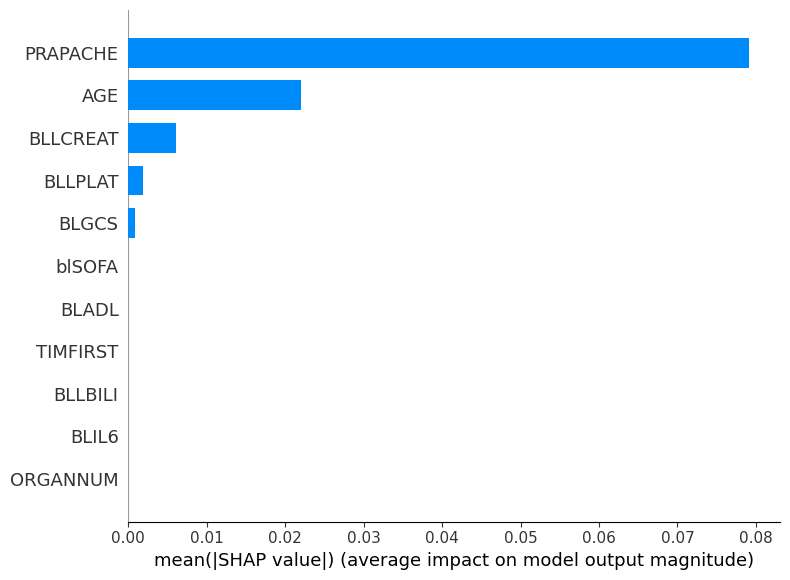

In [127]:
KF_reg = shap.TreeExplainer(reg_KF)
shap_KF_reg = KF_reg.shap_values(X_train_features)

shap.summary_plot(shap_KF_reg, X_train_features, plot_type="bar", show=True)

Classification Tree Explanations

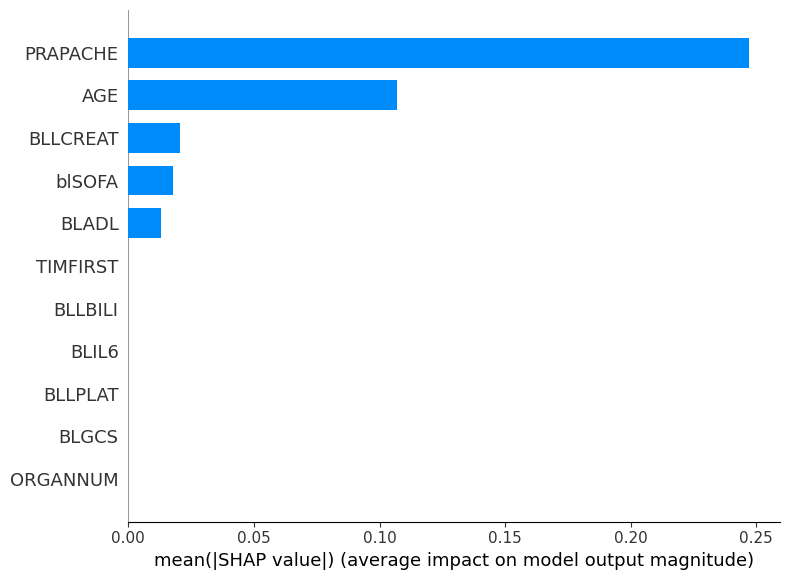

In [145]:
SRF_class = shap.TreeExplainer(classification_trees_SRF[closest_key])
shap_SRF_class = SRF_class(X_features  )
shap_values_SRF = shap_SRF_class[:, :, 1]

shap.summary_plot(shap_values_SRF, X_features, plot_type="bar", show=True)

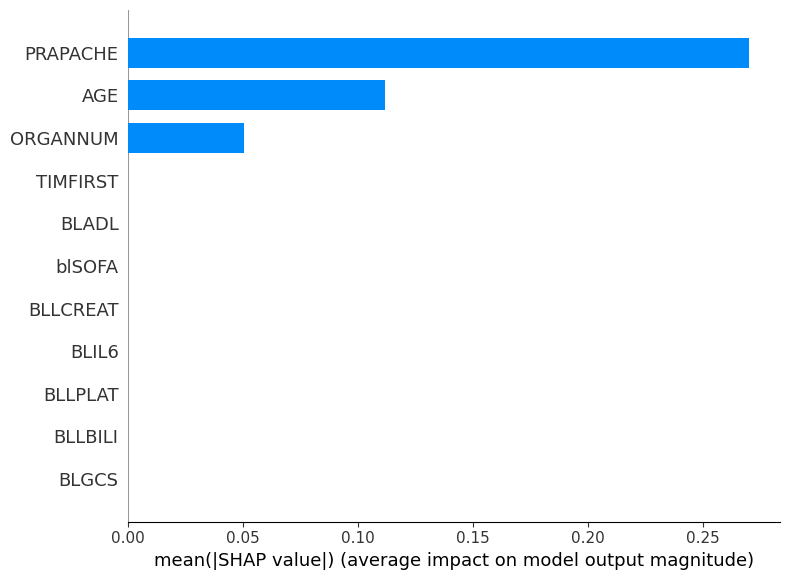

In [146]:
DRF_class = shap.TreeExplainer(classification_trees_DRF [closest_key])
shap_DRF_class = DRF_class(X_features)
shap_values_DRF = shap_DRF_class[:, :, 1]


shap.summary_plot(
    shap_values_DRF, 
    X_features, 
    plot_type="bar", 
    show=True)

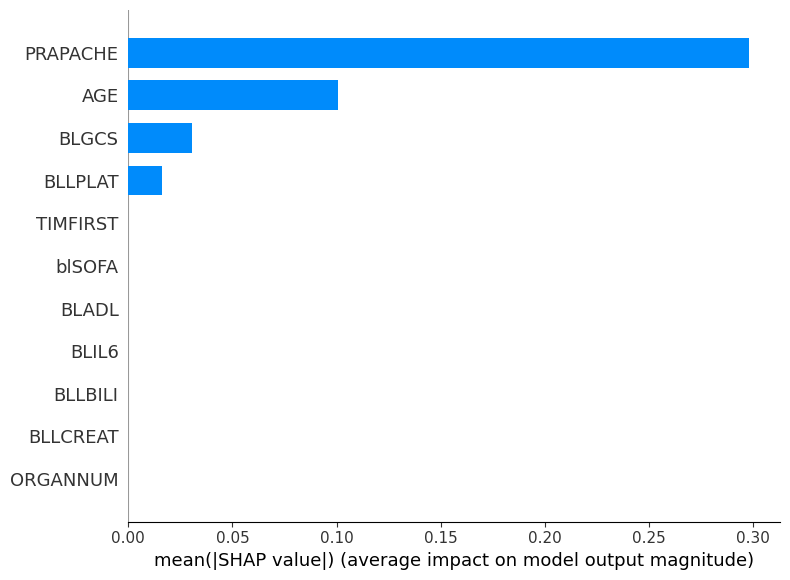

In [147]:
KF_class = shap.TreeExplainer(classification_trees_KF[closest_key])
shap_KF_class = KF_class(X_features)
shap_values_responder = shap_KF_class[:, :, 1]

plt.figure()
shap.summary_plot(
    shap_values_responder, 
    X_features, 
    plot_type="bar", 
    show=True)

# plt.figure(figsize=(10, 6)) 

# shap.plots.bar(
#     shap_values_responder, 
#     max_display=12, 
#     show=False)
# plt.title("Feature Importance for Classification Tree Rules", fontsize=14)
# plt.xlabel("mean(|SHAP value|) (Average impact on defining Responders)")
# plt.show()

Evalduation:

R^2 and Qini

R ^ 2

In [13]:
import statsmodels.api as sm

# Single Random Forest

# Do NOT convert X_test into a Series (that produces a 2D -> 1D mismatch).
# Keep X_test as the DataFrame produced by train_test_split.
# Create a positionally indexed copy of y_test so iloc uses 0..n-1 positions.
y_test_pos = y_test.reset_index(drop=True)

# Get positional indices (np.where on the underlying array gives positions)
treated_idx = np.where(X_test['THERAPY'].to_numpy() == 1)[0]
control_idx = np.where(X_test['THERAPY'].to_numpy() == 0)[0]

# Build 2D feature arrays with two columns: (Twin_1, Twin_2)
treated_features = np.column_stack((Twin_1[treated_idx], Twin_2[treated_idx]))
control_features = np.column_stack((Twin_1[control_idx], Twin_2[control_idx]))

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control_features)
distances, matched_idx = nn.kneighbors(treated_features)

matched_control_idx = control_idx[matched_idx.flatten()]

# Use the positionally reindexed y_test_pos with iloc
pseudo_ITE_SRF = y_test_pos.iloc[treated_idx].to_numpy() - y_test_pos.iloc[matched_control_idx].to_numpy()

linear_reg = sm.add_constant(SRF_ITE[treated_idx])
model = sm.OLS(pseudo_ITE_SRF, linear_reg)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     19.16
Date:                Wed, 03 Dec 2025   Prob (F-statistic):           3.03e-05
Time:                        21:09:40   Log-Likelihood:                -98.275
No. Observations:                  99   AIC:                             200.5
Df Residuals:                      97   BIC:                             205.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1920      0.068      2.814      0.0

In [15]:
#Double Random Forest

# Build 2D feature arrays with two columns: (Twin_1, Twin_2)
treated_features = np.column_stack((twin1_scores[treated_idx], twin2_scores[treated_idx]))
control_features = np.column_stack((twin1_scores[control_idx], twin2_scores[control_idx]))

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control_features)
distances, matched_idx = nn.kneighbors(treated_features)

matched_control_idx = control_idx[matched_idx.flatten()]

# Use the positionally reindexed y_test_pos with iloc
pseudo_ITE_SRF = y_test_pos.iloc[treated_idx].to_numpy() - y_test_pos.iloc[matched_control_idx].to_numpy()

linear_reg = sm.add_constant(DRF_ITE[treated_idx])
model = sm.OLS(pseudo_ITE_SRF, linear_reg)
results = model.fit()

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     5.495
Date:                Wed, 03 Dec 2025   Prob (F-statistic):             0.0211
Time:                        21:18:36   Log-Likelihood:                -88.417
No. Observations:                  99   AIC:                             180.8
Df Residuals:                      97   BIC:                             186.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2315      0.061      3.821      0.0

In [17]:
# K Fold

# Build 2D feature arrays with two columns: (Twin_1, Twin_2)
treated_features = np.column_stack((P1_vec[treated_idx], P0_vec[treated_idx]))
control_features = np.column_stack((P1_vec[control_idx], P0_vec[control_idx]))

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control_features)
distances, matched_idx = nn.kneighbors(treated_features)

matched_control_idx = control_idx[matched_idx.flatten()]

# Use the positionally reindexed y_test_pos with iloc
pseudo_ITE_SRF = y_test_pos.iloc[treated_idx].to_numpy() - y_test_pos.iloc[matched_control_idx].to_numpy()

linear_reg = sm.add_constant(KF_ITE[treated_idx])
model = sm.OLS(pseudo_ITE_SRF, linear_reg)
results = model.fit()

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.5822
Date:                Wed, 03 Dec 2025   Prob (F-statistic):              0.447
Time:                        21:20:05   Log-Likelihood:                -91.339
No. Observations:                  99   AIC:                             186.7
Df Residuals:                      97   BIC:                             191.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2922      0.063      4.607      0.0

Qini